In [2]:
%matplotlib notebook

# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, colors
import matplotlib.colors as mcolors

import h5py
import os
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
# from matplotlib import pyplot as colors
from scipy.signal import medfilt
from matplotlib.colors import LogNorm
from matplotlib_scalebar.scalebar import ScaleBar
from skimage.filters import threshold_otsu #, threshold_adaptive
from scipy import ndimage
from tqdm import tqdm
import time
from multiprocessing import Pool
import scipy.linalg as la
import threading
from matplotlib.widgets import Button

import pandas as pd


def fitRsEL(file, area = 22.04, plot = False):
	def cleanImage(img, bg, threshold = 3):
		mask = img > (img.mean() + threshold*img.std())	#flag values * std devs over the mean
		medvals = medfilt(img, 3) #3x3 median filter
		medvals[(0,0,-1,-1),(0,-1,0,-1)] = img[(0,0,-1,-1),(0,-1,0,-1)]# corner values become 0, not useful. Set back to original value
		img[mask] = medvals[mask]
		return img - bg

	## load data
	with h5py.File(file, 'r') as f:
		title = f['info']['name'][()].decode('utf-8')
		notes = f['settings']['notes'][()]
		idx = [b'Rse' in x for x in notes]
		
		#throw away the first five points, give a more linear calibration constant fit.
		points_to_exclude = 5
		exclude = 0
		for i in range(len(idx)):
			if idx[i] == True:
				idx[i] == False
			if exclude >= points_to_exclude:
				break


		fov = f['settings']['camerafov'][()]/10000	#camera FOV, converted from um to cm
		vmeas = f['data']['v'][()][idx]
		jmeas = f['data']['i'][()][idx] / area
		img = [f['data']['image'][x,:,:] for x in range(f['data']['image'].shape[0]) if idx[x]]
		img = np.array(img)
		bg = f['data']['image'][0,:,:]

	bg = cleanImage(bg, 0, 1)	#hot pixel removal on background image

	## theshold image to exclude background
	def findBoundingRectangle(mask):
		xmin = 1000
		xmax = 0
		ymin = 1000
		ymax = 0
	
		for c, v in np.ndenumerate(mask):
			if v:
				if c[0] < xmin:
					xmin = c[0]
				if c[0] > xmax:
					xmax = c[0]
				if c[1] < ymin:
					ymin = c[1]
				if c[1] > ymax:
					ymax = c[1]
			
		rectMask = np.zeros(mask.shape)
		rectMask[xmin:xmax, ymin:ymax] = 1
		return rectMask == 1


	thresholdImg = cleanImage(img[-1, :, :].copy(), bg, 1.5)
	brightimg = cleanImage(thresholdImg, bg, 1.5)
	global_thresh = threshold_otsu(brightimg)
	mask = brightimg > global_thresh
	mask = ndimage.binary_erosion(mask, iterations = 5)	#get rid of speckles
	mask = ndimage.binary_dilation(mask, iterations = 10) 
	mask = findBoundingRectangle(mask)

	## Clean up data for Rs fitting
	numpts = img.shape[0]-1
	kB = 8.617330e-5
	T = 296
	q = 1
	UT = kB*T/q  # in V

	v = np.zeros((numpts,))
	dv = np.zeros((numpts,))
	j = np.zeros((numpts,))
	phiI = np.zeros((numpts, img.shape[1], img.shape[2]))
	dphiI = np.zeros((numpts, img.shape[1], img.shape[2]))
	sumphi = np.zeros((numpts,))

	for i in range(numpts):
		v[i] = (vmeas[i] + vmeas[i+1])/2
		j[i] = (jmeas[i] + jmeas[i+1])/2
		dv[i] = vmeas[i+1] - vmeas[i]

		im1 = img[i, :, :] - bg
		im1[im1 < 0] = 0
		im2 = img[i+1, :, :] - bg
		im2[im2 < 0] = 0

		phiI[i] = (im1 + im2) / 2
		dphiI[i] = im2 - im1
		sumphi[i] = phiI[i][mask].sum()

	imeas = j*area

	## calibration constant
	areaPerPixel = area / mask.sum()
	calfit = np.polyfit(j*mask.sum(), sumphi, 1)
	CiJoi = calfit[0]

	plt.plot(j*mask.sum(), sumphi)
	plt.plot(j*mask.sum(), j*mask.sum()*calfit[0] + calfit[1], linestyle = ':')
	plt.xlabel('amps/cm2/pixel')
	plt.ylabel(u'$\Sigma\Phi$')
	plt.show()

	time.sleep(1)
	## Rs fitting
	def fitRse(phiI, dphiI):
		x = np.divide(dphiI, dv)
		y = UT * np.divide(x, phiI)
		try:
			pfit = np.polyfit(x,y,1)
			rse = -CiJoi * pfit[0] / pfit[1]
		except:
			rse = np.nan
			
		return rse

	vm = phiI.shape[1]
	vn = phiI.shape[2]

	Rse = np.zeros((vm,vn))

	with tqdm(total = vm*vn, desc = 'Fitting Rse') as pb:
		for m in range(vm):
			for n in range(vn):
		#         Rse[m,n] = pool.apply(fitRse(phiI[:,m,n], dphiI[:,m,n]))
				if mask[m,n]:
					Rse[m,n] = fitRse(phiI[:,m,n], dphiI[:,m,n])
				else:
					Rse[m,n] = np.nan                    
				pb.update(1)

	## write fits to h5 file
	with h5py.File(file, 'a') as d:
		if 'fits' in d.keys():
			fits = d['fits']
		else:
			fits = d.create_group('/fits')

		_fillDataset(d['fits'], 'Rs_EL', Rse, 'Local series resistance (ohm*cm^2) calculated by fitting electroluminescence data.')
		# fillDataset(d['fits'], 'celltype', celltype.encode('utf-8'), 'Cell architecture assumed during fitting.')
		# fillDataset(d['fits'], 'wl_eva', wl_eva, 'Wavelength used as EVA absorbance point.')
		# fillDataset(d['fits'], 'wl_h2o', wl_h2o, 'Wavelength used as water absorbance point.')
		# fillDataset(d['fits'], 'wl_ref', wl_ref, 'Wavelength used as reference absorbance point.')
		# fillDataset(d['fits'], 'poly', [p1, p2], 'Polynomial fit coefficients used to convert absorbances to water content. From highest to lowest order.')
		# fillDataset(d['fits'], 'avgref', avgRef, 'Average reflectance at each point')

	## Plotting
	# if plot:
	# 	fig, ax = plt.subplots(1,2, figsize = (10, 8))

	# 	im1 = ax[0].imshow(
	# 		Rse,
	# 		extent = [0, x.max(), 0, y.max()],
	# 		origin = 'lower',
	# 		vmin = 0,
	# 		vmax = 2
	# 	)
	# 	cb = fig.colorbar(im1, ax = ax[0],
	# 					 orientation="horizontal",fraction=0.068,anchor=(1.0,0.0), pad = 0.01)
	# 	cb.set_label('$[H_{2}O]$  $(mg/cm^3)$')
	# 	ax[0].set_title('Water Map')
	# 	ax[0].axis('off')


	# 	im2 = ax[1].imshow(
	# 		avgRef,
	# 		extent = [0, x.max(), 0, y.max()],
	# 		origin = 'lower',
	# 		vmin = 0
	# 	)
	# 	cb = plt.colorbar(im2, ax = ax[1],
	# 					 orientation="horizontal",fraction=0.068,anchor=(1.0,0.0), pad = 0.01)
	# 	cb.set_label('Reflectance')
	# 	ax[1].set_title('Avg Reflectance')
	# 	plt.axis('off')
	# 	scalebar = ScaleBar(
	# 		dx = 1e-3,
	# 		location = 'lower right',
	# 		color = [1, 1, 1],
	# 		box_alpha = 0
	# 	)
	# 	ax[1].add_artist(scalebar)
	# 	plt.tight_layout()
	# 	plt.show()

def fitPLIV(fpath, area = 22.04):
	#define constants
	k = 1.38e-23 #J/K
	qC = 1.6022e-19 #C
	T = 298.14 #K
	Vt = k*T/qC
	area = area/1e4 #convert cm2 to m2

	###load PLIV data
	with h5py.File(fpath, 'r') as d:
		idx = [i for i, x in enumerate(d['settings']['notes'][()]) if b'PLIV' in x]
		measCurr = d['data']['i'][idx]
		measVolt = d['data']['v'][idx]
		imgs = d['data']['image_bgc'][idx]
		suns = d['settings']['suns'][idx]
		setVolt = d['settings']['vbias'][idx]

	# imgs[imgs<=0] = 1e-4	#avoid breaking log functions down the road
	#locate short-circuit PL images per laser intensity to use for background subtraction
	correctionImgs = {}
	correctionJscs = {}
	dataIdx = []
	for suns_, setVolt_, img_, measCurr_ in zip(suns, setVolt, imgs, measCurr):
		if setVolt_ == 0:
			correctionImgs[suns_] = img_.copy()
			correctionJscs[suns_] = measCurr_/area
			dataIdx.append(False)
		elif setVolt_ <= 0.55 and suns_ <= 0.4:
			dataIdx.append(False)
		else:
			dataIdx.append(True)
	#### remove background from all images, find Voc and Mpp 1 sun images. discard correction images from the dataset		
	# find Voc image
	imgVoc = imgs[0].copy() - correctionImgs[suns_.max()]
	
	# find MPP image
	allSetVolts = np.unique(setVolt)
	allSetVolts.sort()
	mppVolt = allSetVolts[1] #second value of sorted list of bias voltages (first value = 0 for short circuit images)
	allmppIdx = np.where(setVolt == mppVolt)
	oneSunIdx = np.where(suns == 1.0)
	mppIdx = np.intersect1d(allmppIdx, oneSunIdx)[0]
	imgMPP = imgs[mppIdx].copy() - correctionImgs[suns_.max()]
	voltMPP = measVolt[mppIdx].copy()
	# voltMPP = measVolt[mppIdx]

	imgVoc[imgVoc < 0] = 0
	imgMPP[imgMPP < 0] = 0


	numimgs = imgs.shape[0]
	numrows = 5
	numcols = np.ceil(numimgs/numrows).astype(int)

	fig, ax = plt.subplots(numrows, numcols, figsize = (12,12))

	for idx, img_, suns_, ax_ in zip(range(suns.shape[0]), imgs, suns, ax.ravel()):
		imgs[idx] = img_ - correctionImgs[suns_]
		imgs[idx][imgs[idx] < 0] = 0
		ax_.imshow(imgs[idx])

	# throw away short circuit images
	imgs = imgs[dataIdx]
	measCurr = measCurr[dataIdx]
	measVolt = measVolt[dataIdx]
	suns = suns[dataIdx]
	setVolt = setVolt[dataIdx]

	###generate matrix to solve PLIV. 
	#matrix 1: p x q x numimages x 4 (unity, Jsc (A/m2), Photon flux Phi (PL - short-circuit counts), sqrt(Phi))
	#matrix 2: p x q x numimages x 1 (Vthermal * log(Phi) - Vterminal)
	M = np.ones((imgs.shape[1], imgs.shape[2], imgs.shape[0], 4))
	N = np.ones((imgs.shape[1], imgs.shape[2], imgs.shape[0]))
	for idx, img_, suns_, measV_, measC_, setV_ in zip(range(suns.shape[0]), imgs, suns, measVolt, measCurr, setVolt):
		M[:,:,idx,1] = -correctionJscs[suns_]
		# img_[img_<= 0] = 0
		M[:,:,idx,2] = img_
		M[:,:,idx,3] = np.sqrt(img_)
		# img_[img_<= 0] = 1e-20
		N[:,:,idx] = Vt * np.log(img_) - measV_

	# solve matrix, process into each fit
	x = np.full((imgs.shape[1], imgs.shape[2], 4), np.nan)

	for p,q in tqdm(np.ndindex(imgs[0].shape), total = imgs[0].ravel().shape[0]):
		x[p,q] = np.linalg.lstsq(M[p,q], N[p,q], rcond = 0)[0]
		# Q,R,perm = la.qr(M[p,q], pivoting = True)
		# print(perm)
		# Qb = np.matmul(Q.T, N[p,q])
		# x[p,q] = np.linalg.lstsq(R, Qb, rcond = None)[0]
		# print(x[p,q].shape)
		# x[p,q] = x[p,q][perm]


	C = np.exp(x[:,:,0]/Vt)
	Rs = x[:,:,1]*1e4	#convert to ohm cm^2
	J01 = x[:,:,2]*C/Rs
	J02 = x[:,:,3]*np.sqrt(C)/Rs

	Voc1sun = Vt*np.log(imgVoc/C)
	Vmpp1sun = Vt*np.log(imgMPP/C)

	Jmpp1sun = -J01*(np.exp(Vmpp1sun/Vt) - 1) - J02*(np.exp(Vmpp1sun/(2*Vt))-1) + correctionJscs[suns.max()]
	FF1sun = (voltMPP*Jmpp1sun) / (correctionJscs[suns.max()]*Voc1sun)
	nu1sun = Vmpp1sun*-Jmpp1sun / (1e3)	#divided by incident power, assuming 1000 w/m2


	result = {
		'x': x,
		'C': C,
		'Rs': Rs,
		'J01': -J01,
		'J02': -J02,
		'Voc': Voc1sun,
		'Vmpp': Vmpp1sun,
		'Jmpp': -Jmpp1sun * 0.1, #convert A/m2 -> mA/cm2
		'FF': FF1sun * 100, #convert to percent
		'Efficiency': nu1sun,
		'imgVoc': imgVoc,
		'imgMPP': imgMPP
	}

	# for k, v in result.items():
	# 	result[k][v < 0] = np.nan

	# plt.show()

	with h5py.File(fpath, 'a') as d:
		if 'fits' in d.keys():
			fits = d['fits']
		else:
			fits = d.create_group('/fits')

		_fillDataset(d['fits'], 'Rs_PLIV', result['Rs'], 'Local series resistance (ohm*cm^2) calculated by fitting PLIV data.')
		_fillDataset(d['fits'], 'J01', result['J01'], 'Local J01 calculated by fitting PLIV data.')
		_fillDataset(d['fits'], 'J02', result['J02'], 'Local J02 calculated by fitting PLIV data.')
		_fillDataset(d['fits'], 'Voc', result['Voc'], 'Local Voc (V) calculated by fitting PLIV data.')
		_fillDataset(d['fits'], 'Vmpp', result['Vmpp'], 'Local Vmpp (V) calculated by fitting PLIV data.')
		_fillDataset(d['fits'], 'Jmpp', result['Jmpp'], 'Local Jmpp (mA/cm2) calculated by fitting PLIV data.')
		_fillDataset(d['fits'], 'FF', result['FF'], 'Local fill factor calculated by fitting PLIV data.')
		_fillDataset(d['fits'], 'Efficiency', result['Efficiency'], 'Local efficiency calculated by fitting PLIV data.')

def harmonic_mean_2d_all(arr):
    flattened_arr = arr.flatten()
    valid_values = flattened_arr[(flattened_arr != 0) & (~np.isnan(flattened_arr)) & (~np.isinf(flattened_arr)) & (flattened_arr > 0)]  # Exclude NaN values
#     print(len(flattened_arr), len(valid_values))
    return len(valid_values) / np.sum(1 / valid_values), np.sum(valid_values) / len(valid_values), valid_values #np.mean(valid_values)

# eff_arr_test = result['FF (%)']

# harmonic_mean_all, arith_mean_all, test_valid_values = harmonic_mean_2d_all(eff_arr_test)
# print('arith mean', (arith_mean_all), 'harmo mean', (harmonic_mean_all))
        
def ManualRegistrationSelection(file, **kwargs):
	with h5py.File(file, 'a') as d:
		# use average reflectance as reference to pick corners 
		regImg = d['data']['image_bgc'][-2] #Highest Bias + Suns image for corner location
		p = ImagePointPicker(regImg, pts = 4, **kwargs)

		# add points to fits group.
		if 'fits' in d.keys():
			fits = d['fits']
		else:
			fits = d.create_group('fits')

		_fillDataset(d['fits'], 'registrationpoints', p, 'Four corners of cell, used for registration. Points are ordered top right, top left, bottom left, bottom right, assuming that the cell is oriented with the busbar horizontal and closer to the top edge of the cell')

def BatchManualRegistrationSelection(directory, overwrite = False, **kwargs):
	def traverse_files(f, files = [], first = True):
		if first:
			for f_ in tqdm(os.listdir(f)):
				f__ = os.path.join(f, f_)
				if os.path.isdir(f__):
					files = traverse_files(f__, files, first = False)
				else:
					if f__[-3:] == '.h5':
						try:
							with h5py.File(f__, 'r') as d:
								if 'fits/registrationpoints' not in d:
									files.append(f__)
						except:
							pass
		else:
			for f_ in os.listdir(f):
				f__ = os.path.join(f, f_)
				if os.path.isdir(f__):
					files = traverse_files(f__, files, first = False)
				else:
					if f__[-3:] == '.h5':
						try:
							with h5py.File(f__, 'r') as d:
								if 'fits/registrationpoints' not in d:
									files.append(f__)
						except:
							pass			
		return files

	for f in tqdm(traverse_files(directory)):
		try:
			ManualRegistrationSelection(f, **kwargs)
		except:
			print('Error fitting {0}'.format(f))

# def BatchManualRegistrationSelection(directory, overwrite = False, **kwargs):
# 	class fobject():
# 		def __init__(self, directory = directory):
# 			self.rootdir = directory
# 			self.files = []
		
# 		def traverse_files(self, f = None):
# 			if f is None:
# 				f = self.rootdir
# 			for f_ in tqdm(os.listdir(f)):
# 				f__ = os.path.join(f, f_)
# 				if os.path.isdir(f__):
# 					self.traverse_files(f__)
# 				else:
# 					if f__[-3:] == '.h5':
# 						try:
# 							with h5py.File(f__, 'r') as d:
# 								if not overwrite and 'fits/registrationpoints' not in d:
# 									self.files.append(f__)
# 						except:
# 							pass

# 	fileobject = fobject(directory = directory)
# 	traverse_thread = threading.Thread(target = fileobject.traverse_files)
# 	print('Starting to search for PL data files...')
# 	traverse_thread.start()
	
# 	time.sleep(0.1)

# 	file_idx = 0
# 	startTime = time.time()
# 	while traverse_thread.is_alive() or file_idx < len(fileobject.files):
# 		if file_idx < len(fileobject.files):		
# 			if file_idx > 0:
# 				print('{0}/{1}, {2:.0f} s remaining'.format(file_idx, len(fileobject.files), (time.time()-startTime)*(len(fileobject.files)-file_idx)/file_idx))
# 			try:
# 				ManualRegistrationSelection(fileobject.files[file_idx], **kwargs)
# 			except:
# 				print('Error fitting {0}'.format(fileobject.files[file_idx]))
# 			file_idx += 1
# 		else:
# 			time.sleep(0.2)

## Image registration point picking. Taken from frgtools.imageprocessing
class __ImgPicker():
	def __init__(self, img, pts, markersize = 0.3, **kwargs):
		self.numPoints = pts
		self.currentPoint = 0
		self.finished = False
		self.markersize = markersize

		self.fig, self.ax = plt.subplots()
		self.ax.imshow(img, picker = True, **kwargs)
		self.fig.canvas.mpl_connect('pick_event', self.onpick)

		self.buttonAx = plt.axes([0.4, 0, 0.1, 0.075])
		self.stopButton = Button(self.buttonAx, 'Done')
		self.stopButton.on_clicked(self.setFinished)

		self.pickedPoints = [None for x in range(self.numPoints)]
		self.pointArtists = [None for x in range(self.numPoints)]
		self.pointText = [None for x in range(self.numPoints)]

		plt.show(block = True)        
	
	def setFinished(self, event):
		self.finished = True
		plt.close(self.fig)
	
	def onpick(self, event):
		if not self.finished:
			mevt = event.mouseevent
			idx = self.currentPoint % self.numPoints
			self.currentPoint += 1

			x = mevt.xdata
			y = mevt.ydata
			self.pickedPoints[idx] = [x,y]

			if self.pointArtists[idx] is not None:
				self.pointArtists[idx].remove()
			self.pointArtists[idx] = plt.Circle((x,y), self.markersize, color = [1,1,1])
			self.ax.add_patch(self.pointArtists[idx])

			if self.pointText[idx] is not None:
				self.pointText[idx].set_position((x,y))
			else:
				self.pointText[idx] = self.ax.text(x,y, '{0}'.format(idx), color = [0,0,0], ha = 'center', va = 'center')
				self.ax.add_artist(self.pointText[idx])

			self.fig.canvas.draw()
			self.fig.canvas.flush_events()

def ImagePointPicker(img, pts = 4, **kwargs):
	"""
	Given an image and a number of points, allows the user to interactively select points on the image.
	These points are returned when the "Done" button is pressed. Useful to generate inputs for AffineCalculate.
	"""
	imgpicker = __ImgPicker(img, pts, **kwargs)
	return imgpicker.pickedPoints


## write fits to h5 file
def _fillDataset(d, name, data, description):
	if name in d.keys():
		del d[name]
	temp = d.create_dataset(name, data = data)
	temp.attrs['description'] = description

<IPython.core.display.Javascript object>


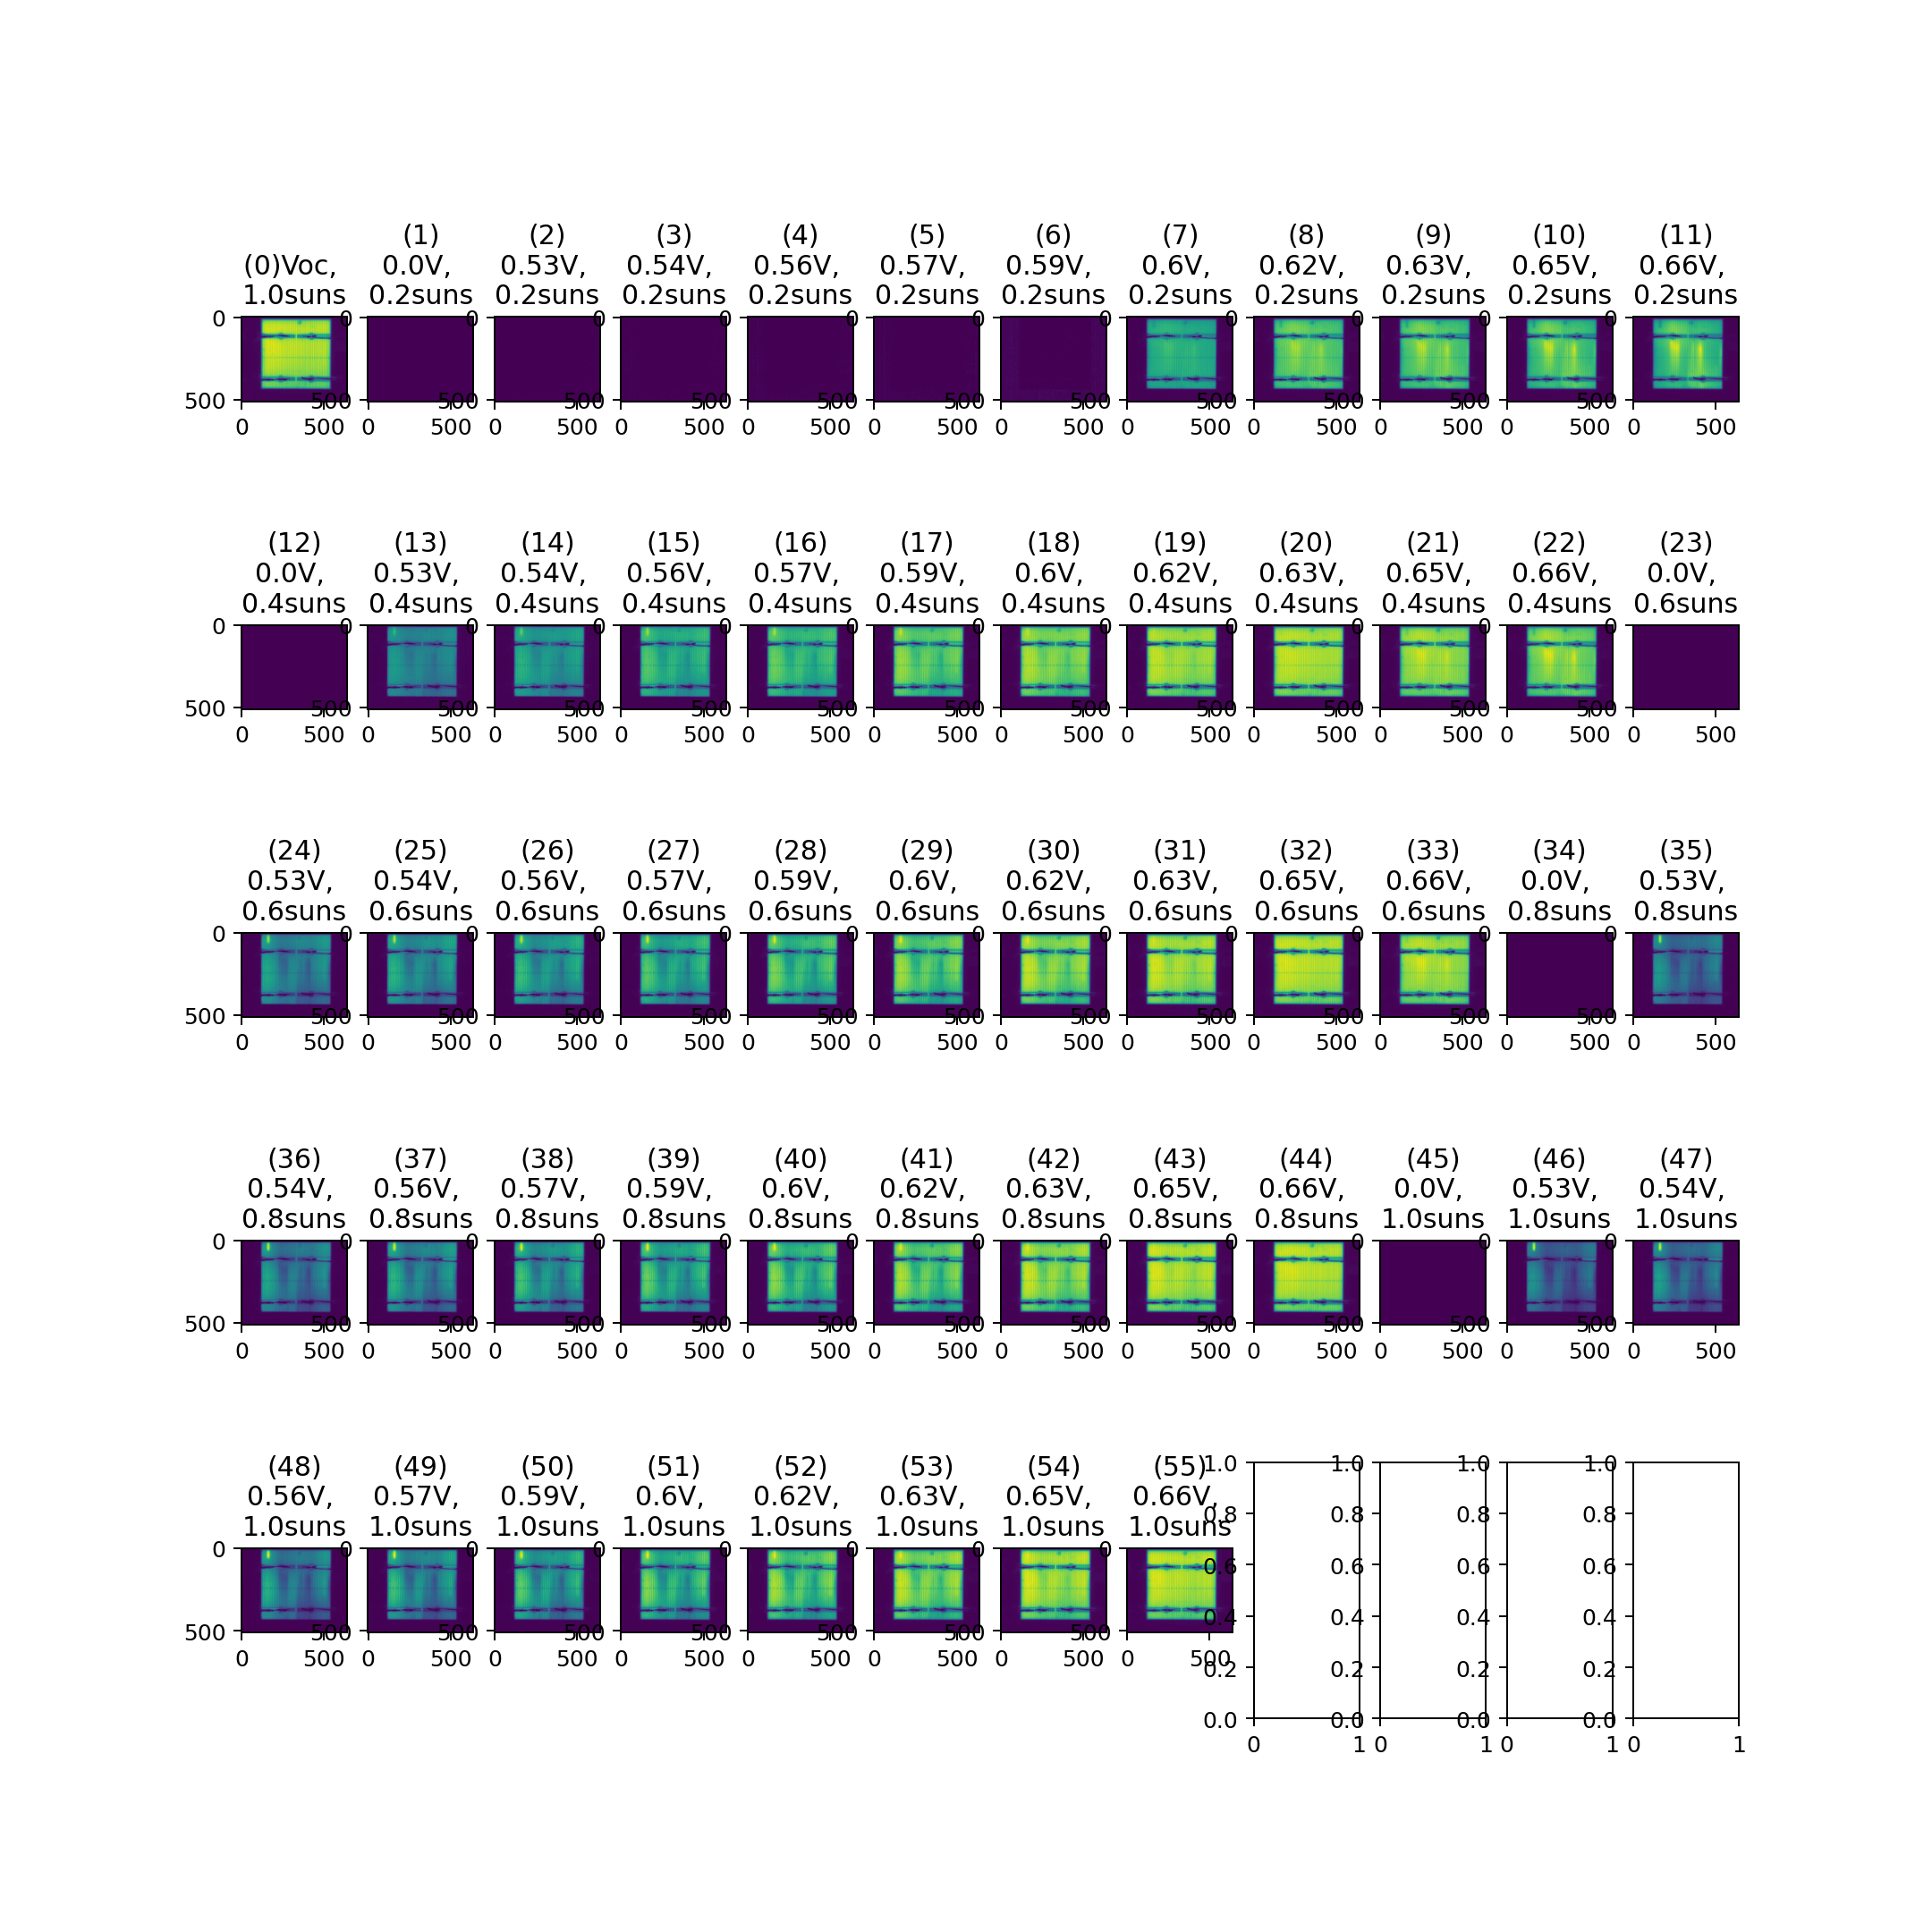

C:\Users\FRG-users\AppData\Local\Temp\ipykernel_21300\2171571276.py:98: RuntimeWarning: divide by zero encountered in log
  N[:,:,idx] = Vt * np.log(img_) - measV_
100%|██████████| 327680/327680 [00:16<00:00, 20220.52it/s]


In [41]:
#define constants
k = 1.38e-23 #J/K
qC = 1.6022e-19 #C
T = 298.14 #K
Vt = k*T/qC
area = 25.81 #cm2
area = area/1e4 #convert cm2 to m2

fpath = "F:\\x20240808\\Data\\20240808\\frgPL_20240808_0018.h5"


###load PLIV data
with h5py.File(fpath, 'r') as d:
    idx = [i for i, x in enumerate(d['settings']['notes'][()]) if b'PLIV' in x]
    measCurr = d['data']['i'][idx]
    measVolt = d['data']['v'][idx]
    imgs = d['data']['image_bgc'][idx]# + baseline_img
    suns = d['settings']['suns'][idx]
    setVolt = d['settings']['vbias'][idx]
    exp_t = d['data']['image_bgc'][idx]

imgs_pre_drop = imgs.copy()
setVolt_pre_drop = setVolt.copy()
suns_pre_drop = suns.copy()
measCurr_pre_drop = measCurr.copy()
measVolt_pre_drop = measVolt.copy()

# imgs[imgs<=0] = 1e-4	#avoid breaking log functions down the road
#locate short-circuit PL images per laser intensity to use for background subtraction
correctionImgs = {}
correctionJscs = {}
dataIdx = []
for suns_, setVolt_, img_, measCurr_ in zip(suns, setVolt, imgs, measCurr):
    if setVolt_ == 0:
        correctionImgs[suns_] = img_.copy()
        correctionJscs[suns_] = measCurr_/area
        dataIdx.append(False)
#     elif setVolt_ <= 0.64 and suns_ <= 0.2:
#         dataIdx.append(False)
    elif suns_ <= 0.2:
        dataIdx.append(False)
    else:
        dataIdx.append(True)
#### remove background from all images, find Voc and Mpp 1 sun images. discard correction images from the dataset		
# find Voc image
imgVoc = imgs[0].copy() - correctionImgs[suns_.max()]

# find MPP image
allSetVolts = np.unique(setVolt)
allSetVolts.sort()
mppVolt = allSetVolts[1] #second value of sorted list of bias voltages (first value = 0 for short circuit images)
allmppIdx = np.where(setVolt == mppVolt)
oneSunIdx = np.where(suns == 1.0)
mppIdx = np.intersect1d(allmppIdx, oneSunIdx)[0]
imgMPP = imgs[mppIdx].copy() - correctionImgs[suns_.max()]
voltMPP = measVolt[mppIdx]#.copy()
# voltMPP = measVolt[mppIdx]

imgVoc[imgVoc < 0] = 0
imgMPP[imgMPP < 0] = 0


numimgs = imgs.shape[0]
numrows = 5
numcols = np.ceil(numimgs/numrows).astype(int)

fig, ax = plt.subplots(numrows, numcols, figsize = (12,12))

for idx, img_, suns_, ax_ in zip(range(suns.shape[0]), imgs, suns, ax.ravel()):
    imgs[idx] = img_ - correctionImgs[suns_]
    imgs[idx][imgs[idx] < 0] = 0
    ax_.imshow(imgs[idx])
    if idx == 0:
        ax_.set_title(f'({idx})Voc, \n{np.round(suns[idx], 2)}suns')
    else:
        ax_.set_title(f'({idx})\n{np.round(setVolt[idx], 2)}V, \n{np.round(suns[idx], 2)}suns')

# throw away short circuit images
imgs = imgs[dataIdx]
measCurr = measCurr[dataIdx]
measVolt = measVolt[dataIdx]
suns = suns[dataIdx]
setVolt = setVolt[dataIdx]

###generate matrix to solve PLIV. 
#matrix 1: p x q x numimages x 4 (unity, Jsc (A/m2), Photon flux Phi (PL - short-circuit counts), sqrt(Phi))
#matrix 2: p x q x numimages x 1 (Vthermal * log(Phi) - Vterminal)
M = np.ones((imgs.shape[1], imgs.shape[2], imgs.shape[0], 4))
N = np.ones((imgs.shape[1], imgs.shape[2], imgs.shape[0]))
for idx, img_, suns_, measV_, measC_, setV_ in zip(range(suns.shape[0]), imgs, suns, measVolt, measCurr, setVolt):
#     M[:,:,idx,0] = 3.8

    M[:,:,idx,1] = -correctionJscs[suns_]
    # img_[img_<= 0] = 0
    M[:,:,idx,2] = img_
    M[:,:,idx,3] = np.sqrt(img_)
    # img_[img_<= 0] = 1e-20
    N[:,:,idx] = Vt * np.log(img_) - measV_

# solve matrix, process into each fit
x = np.full((imgs.shape[1], imgs.shape[2], 4), np.nan)

for p,q in tqdm(np.ndindex(imgs[0].shape), total = imgs[0].ravel().shape[0]):
    mask = np.isfinite(N[p,q])
    M_filtered = M[p,q][mask]
    N_filtered = N[p,q][mask]
    
    x[p,q] = np.linalg.lstsq(M_filtered, N_filtered, rcond = 0)[0]
    # Q,R,perm = la.qr(M[p,q], pivoting = True)
    # print(perm)
    # Qb = np.matmul(Q.T, N[p,q])
    # x[p,q] = np.linalg.lstsq(R, Qb, rcond = None)[0]
    # print(x[p,q].shape)
    # x[p,q] = x[p,q][perm]


C = np.exp(x[:,:,0]/Vt)
Rs = x[:,:,1]*1e4	#convert to ohm cm^2
J01 = x[:,:,2]*C/x[:,:,1] #A/m2
J02 = x[:,:,3]*np.sqrt(C)/x[:,:,1]#A/m2

# Voc1sun = Vt*np.log(imgVoc/C)
# Vmpp1sun = Vt*np.log(imgMPP/C)

# Jmpp1sun = -J01*(np.exp(Vmpp1sun/Vt) - 1) - J02*(np.exp(Vmpp1sun/(2*Vt))-1) + correctionJscs[suns.max()] #A/m2
# FF1sun = (voltMPP*(Jmpp1sun)) / (correctionJscs[suns.max()]*Voc1sun)
# nu1sun = Voc1sun*correctionJscs[1.0]*-1*FF1sun/1e3


result = {
    'x': x,
    'C': C,
    'Rs (ohm*cm2)': Rs,
    'J01 (mA/cm2)': -J01*0.1,
    'J02 (mA/cm2)': -J02*0.1,
#     'Voc (V)': Voc1sun,
#     'Vmpp (V)': Vmpp1sun,
#     'Jmpp (mA/cm2)': -Jmpp1sun * 0.1, #convert A/m2 -> mA/cm2
#     'FF (%)': FF1sun * 100, #convert to percent
#     'Efficiency (%)': nu1sun*100,
#     'imgVoc': imgVoc,
#     'imgMPP': imgMPP
}


### read the JV of the cell

<IPython.core.display.Javascript object>


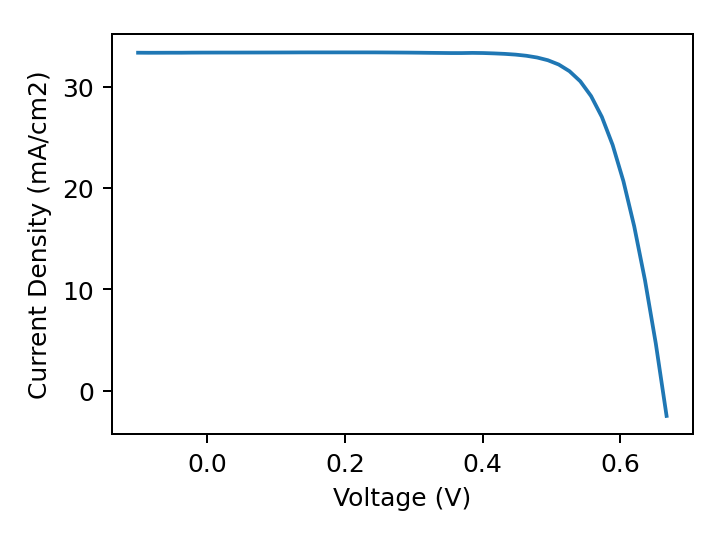

'C:\\Users\\FRG-users\\Documents\\Data\\x20240808\\JV_Stats_PLIV - Copy\\Data\\SiTest_P5_S1_fwd_light.csv'

In [42]:
#read jv of this cell
Module_name = 'SiTest'
Pixel_num = "P5"
Scan_num = "S1"
root_dir = 'C:\\Users\\FRG-users\\Documents\\Data\\x20240808\\JV_Stats_PLIV - Copy\\Data'
JV_dir = os.path.join(root_dir, f"{Module_name}_{Pixel_num}_{Scan_num}_fwd_light.csv")

JV_file = pd.read_csv(JV_dir)
plt.close('all')
plt.figure(figsize = (4, 3))
plt.plot(JV_file['Voltage (V)'], JV_file['Current Density (mA/cm2)'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (mA/cm2)')
plt.tight_layout()
JV_dir

### extract the intrinsic params from the RWTH fitting

In [43]:
fitted_RWTH_vals = [np.nan, 1.387, 1.642e-10, 1.807e-5] # P5
# fitted_RWTH_vals = [np.nan, 0.947, 1.669e-10, 1.59e-05]# P7

#[np.nan, 0.954, 2.487e-10, 2.182e-05]


### select the ROI of interest

<IPython.core.display.Javascript object>


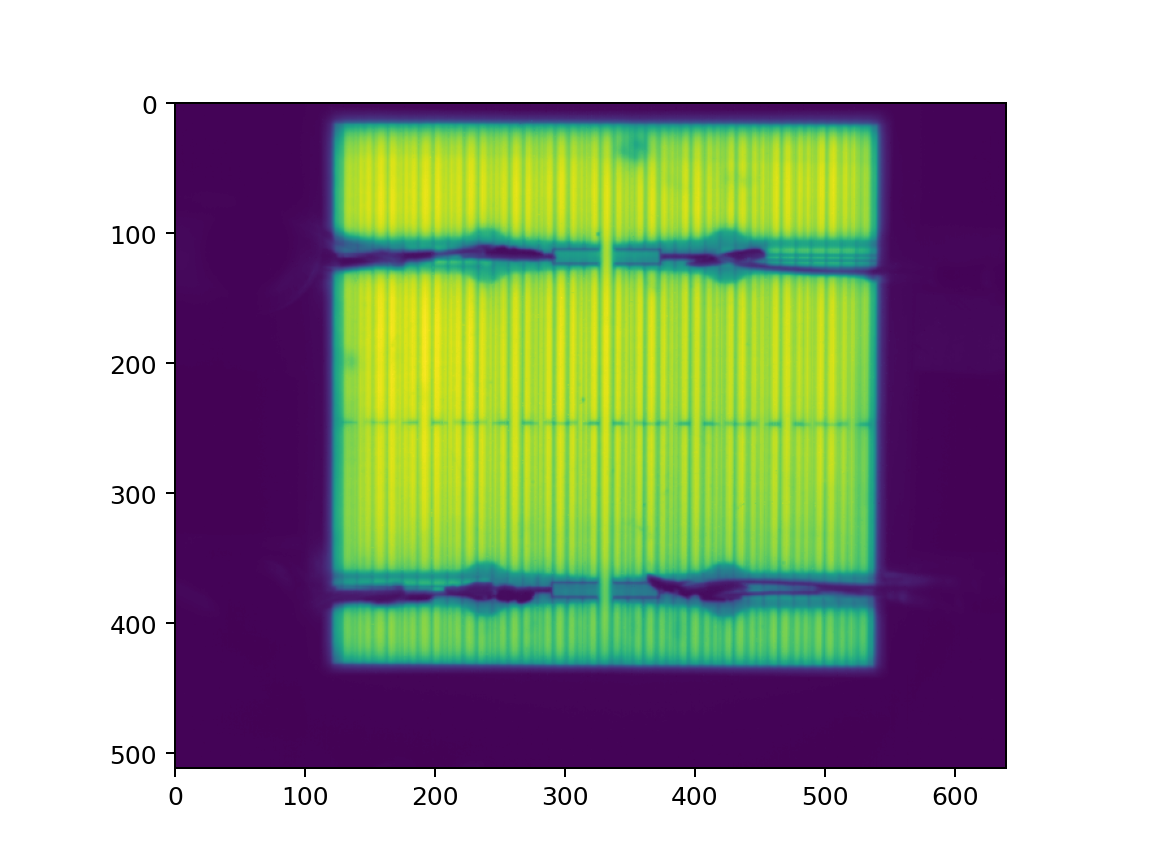

In [44]:
plt.close('all')
plt.imshow(imgs[-1]) #0, 232, 275, 515 #0, 228, 279, 511

### plot out the fitted params, and compare it with JV

<IPython.core.display.Javascript object>


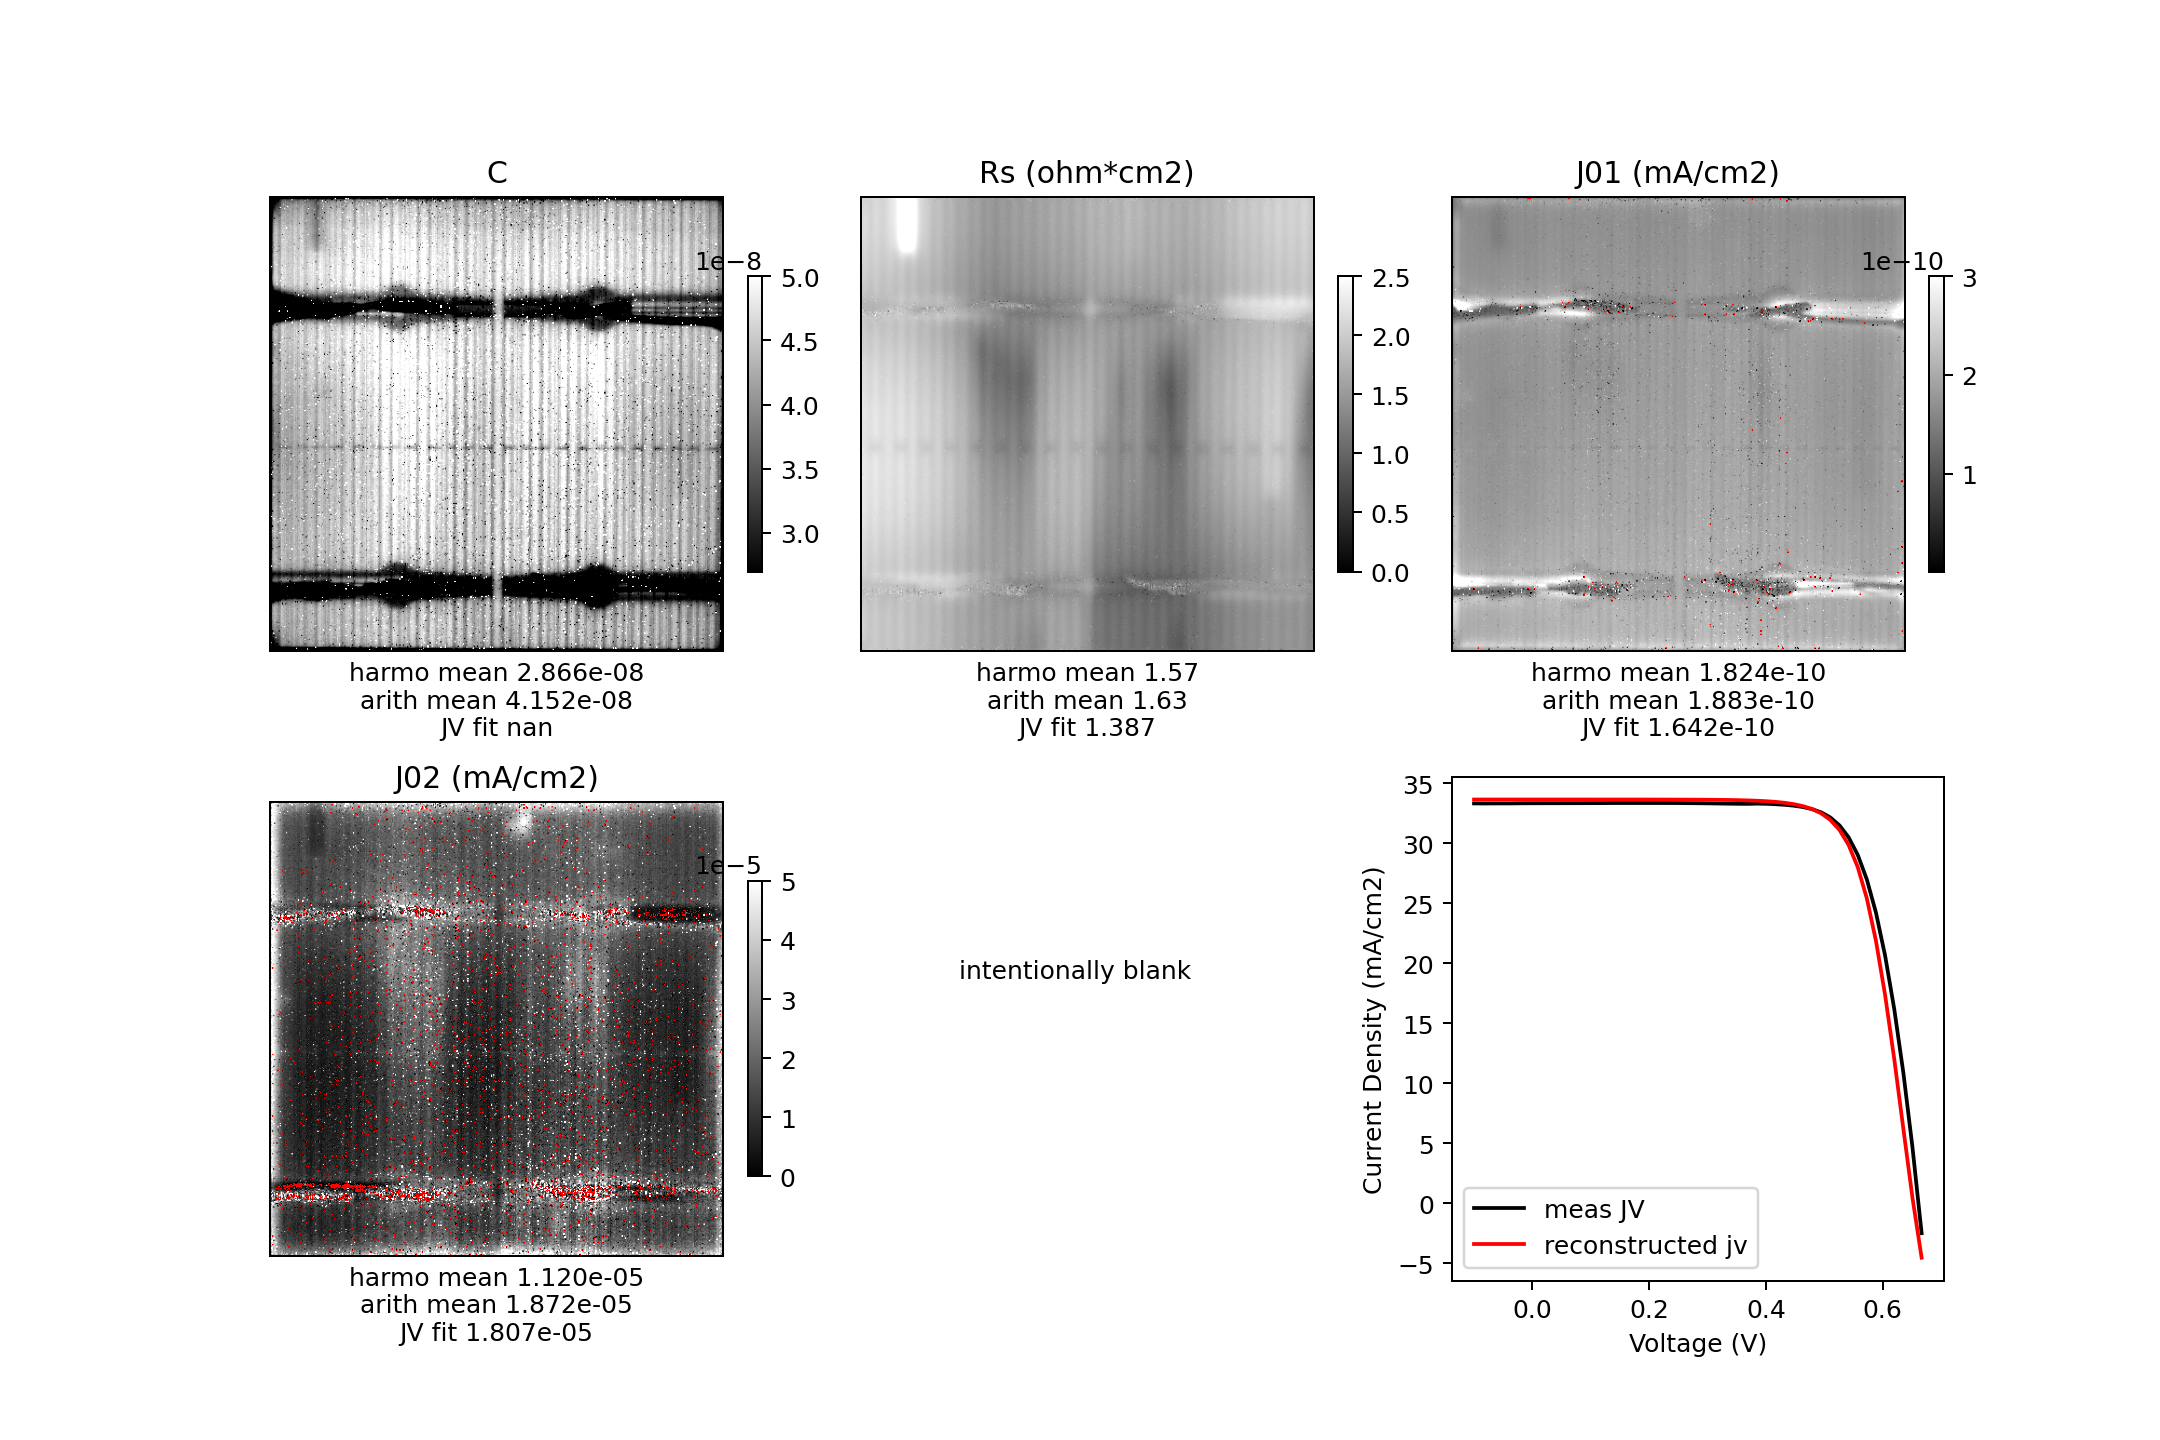

5


In [47]:

y1, y2, x1, x2 = 14, 435, 120, 540
#0, 232, 275, 515
#0, 228, 279, 511

#0, 217, 264, 502 #P5

#263, 495, 247, 485 #P3


#14, 435, 120, 540 P5
#8, 425, 108, 524 P7
A_to_mA = 1000
area = 25.81#cm2

arith_mean_folder = {}

plt.close('all')
fig, ax = plt.subplots(2,3,figsize = (12, 8))
axs = ax.flatten()

for i, ax_ in enumerate(axs):
    try:
        params = list(result.keys())[i+1]# 'Rs'

        cropped_result = result[params][y1:y2, x1:x2]

        to_draw = cropped_result[~np.isinf(cropped_result) & (~np.isnan(cropped_result)) & (cropped_result > 0)]

        mean_ = np.nanmean(to_draw)
        std_ = np.nanstd(to_draw)
        ratio = 1.5
        vmin = mean_ - ratio*std_
        vmax = mean_ + ratio*std_
        if params == 'C': 
            vmin, vmax = 5e-8, 3e-8
        if params == 'Rs (ohm*cm2)': 
            vmin, vmax = 0, 2.5
        if params == 'Voc (V)':
            vmin, vmax = 0.65, 0.675

        if params == 'Vmpp (V)':
            vmin, vmax = 0.53, 0.62
        if params == 'J01 (mA/cm2)':
            vmin, vmax = 1e-12, 3e-10
        if params == 'J02 (mA/cm2)':
            vmin, vmax = 0, 5e-5
        if params == 'Jmpp (mA/cm2)':
            vmin, vmax = 33, 36
        if params == 'FF (%)':
            vmin, vmax = 70, 76
        if params == 'Efficiency (%)':
            vmin, vmax = 18, 19.2

        harmonic_mean_all, arith_mean_all, _ = harmonic_mean_2d_all(to_draw)
        arith_mean_folder[params] = arith_mean_all

        im = ax_.imshow(cropped_result, vmin = vmin, vmax = vmax, cmap = 'gray') #[38:500, 100:610]
        cbar = plt.colorbar(im, ax=ax_, pad=0.05, fraction=0.03)
        ax_.set_xticks([])
        ax_.set_yticks([])

        ax_.set_xticklabels([])
        ax_.set_yticklabels([])

        if harmonic_mean_all < 0.01:
            harmo_display = f"{harmonic_mean_all:.3e}"
        else:  
            harmo_display = np.round(harmonic_mean_all, 3)

        if arith_mean_all < 0.01:  
            arith_display = f"{arith_mean_all:.3e}"
        else:  
            arith_display = np.round(arith_mean_all, 3)

        ax_.set_xlabel(f'harmo mean {harmo_display}\narith mean {arith_display}\nJV fit {fitted_RWTH_vals[i]}')
    #     print()

    #     ax_.axis('off')
        ax_.set_title(f'{params}')

        mask = (cropped_result <= 0) | np.isinf(cropped_result) | np.isinf(-cropped_result) | np.isnan(cropped_result)

        masked_array = np.where(mask == 1, mask, np.nan)

        cmap = mcolors.ListedColormap(['red'])

        ax_.imshow(masked_array, cmap=cmap, interpolation='none')
        
        
    except IndexError:
        if i ==4:
            ax_.text(0.2, 0.6, 'intentionally blank')
            ax_.axis('off')
            pass
        else: 
            print(i)
            ax_.plot(JV_file['Voltage (V)'], JV_file['Current Density (mA/cm2)'], label = 'meas JV', color = 'k')

            v = JV_file['Voltage (V)']
            j = JV_file['Current Density (mA/cm2)']
            j01 = arith_mean_folder['J01 (mA/cm2)']
            j02 = arith_mean_folder['J02 (mA/cm2)']
            rs =  arith_mean_folder['Rs (ohm*cm2)']

            reconstructed_jv_sandia = (33.661) - (j01) * np.exp ((v + (j*area/A_to_mA) *rs/area) / (Vt)) - (j02) * np.exp ((v + (j*area/A_to_mA) *rs/area) / (2*Vt)) 
            ax_.plot(v, reconstructed_jv_sandia, color = 'r', label = 'reconstructed jv')

            ax_.legend()

            ax_.set_xlabel('Voltage (V)')
            ax_.set_ylabel('Current Density (mA/cm2)')

# plt.title('Si Pixel 7')